In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_wide_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=.1, sigma=.1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=2, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=1)
    beta_H = pm.Normal("beta_H", mu=1, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=1, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=3, sigma=1)
    alpha_1 = pm.Normal("alpha_1", mu=3, sigma=1)
    alpha_2 = pm.Normal("alpha_2", mu=3, sigma=1)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.13874934099513656

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 647 seconds.
There were 2336 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB 3.123 3.48 3.327 ... 1.929 4.086 0.9421
     alpha_2  (chain, draw) float64 192kB -1.461 -1.763 -2.007 ... -1.705 -1.342
     alpha_L  (chain, draw) float64 192kB 3.503 2.606 2.465 ... 3.979 3.139 4.138
     beta_H   (chain, draw) float64 192kB 0.7764 0.7553 0.7521 ... 0.741 0.812
     beta_H2  (chain, draw) float64 192kB 0.4467 0.327 0.3249 ... 0.3621 0.4201
     beta_L   (chain, draw) float64 192kB 0.9724 1.033 1.033 ... 1.008 1.011
     eta      (chain, draw) float64 192kB 0.06244 0.05913 ... 0.05925 0.06575
     rho      (chain, draw) float64 192kB 83.07 100.3 99.77 ... 93.18 87.57 103.6
     sigma    (chain, draw) float64 192kB 0.08673 0.08661 ... 0.08484 0.08413
 Attributes:
     created_at:                 2024-0

In [8]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 192kB 3.123 3.48 3.327 ... 1.929 4.086 0.9421
    alpha_2  (chain, draw) float64 192kB -1.461 -1.763 -2.007 ... -1.705 -1.342
    alpha_L  (chain, draw) float64 192kB 3.503 2.606 2.465 ... 3.979 3.139 4.138
    beta_H   (chain, draw) float64 192kB 0.7764 0.7553 0.7521 ... 0.741 0.812
    beta_H2  (chain, draw) float64 192kB 0.4467 0.327 0.3249 ... 0.3621 0.4201
    beta_L   (chain, draw) float64 192kB 0.9724 1.033 1.033 ... 1.008 1.011
    eta      (chain, draw) float64 192kB 0.06244 0.05913 ... 0.05925 0.06575
    rho      (chain, draw) float64 192kB 83.07 100.3 99.77 ... 93.18 87.57 103.6
    sigma    (chain, draw) float64 192kB 0.08673 0.08661 ... 0.08484 0.08413

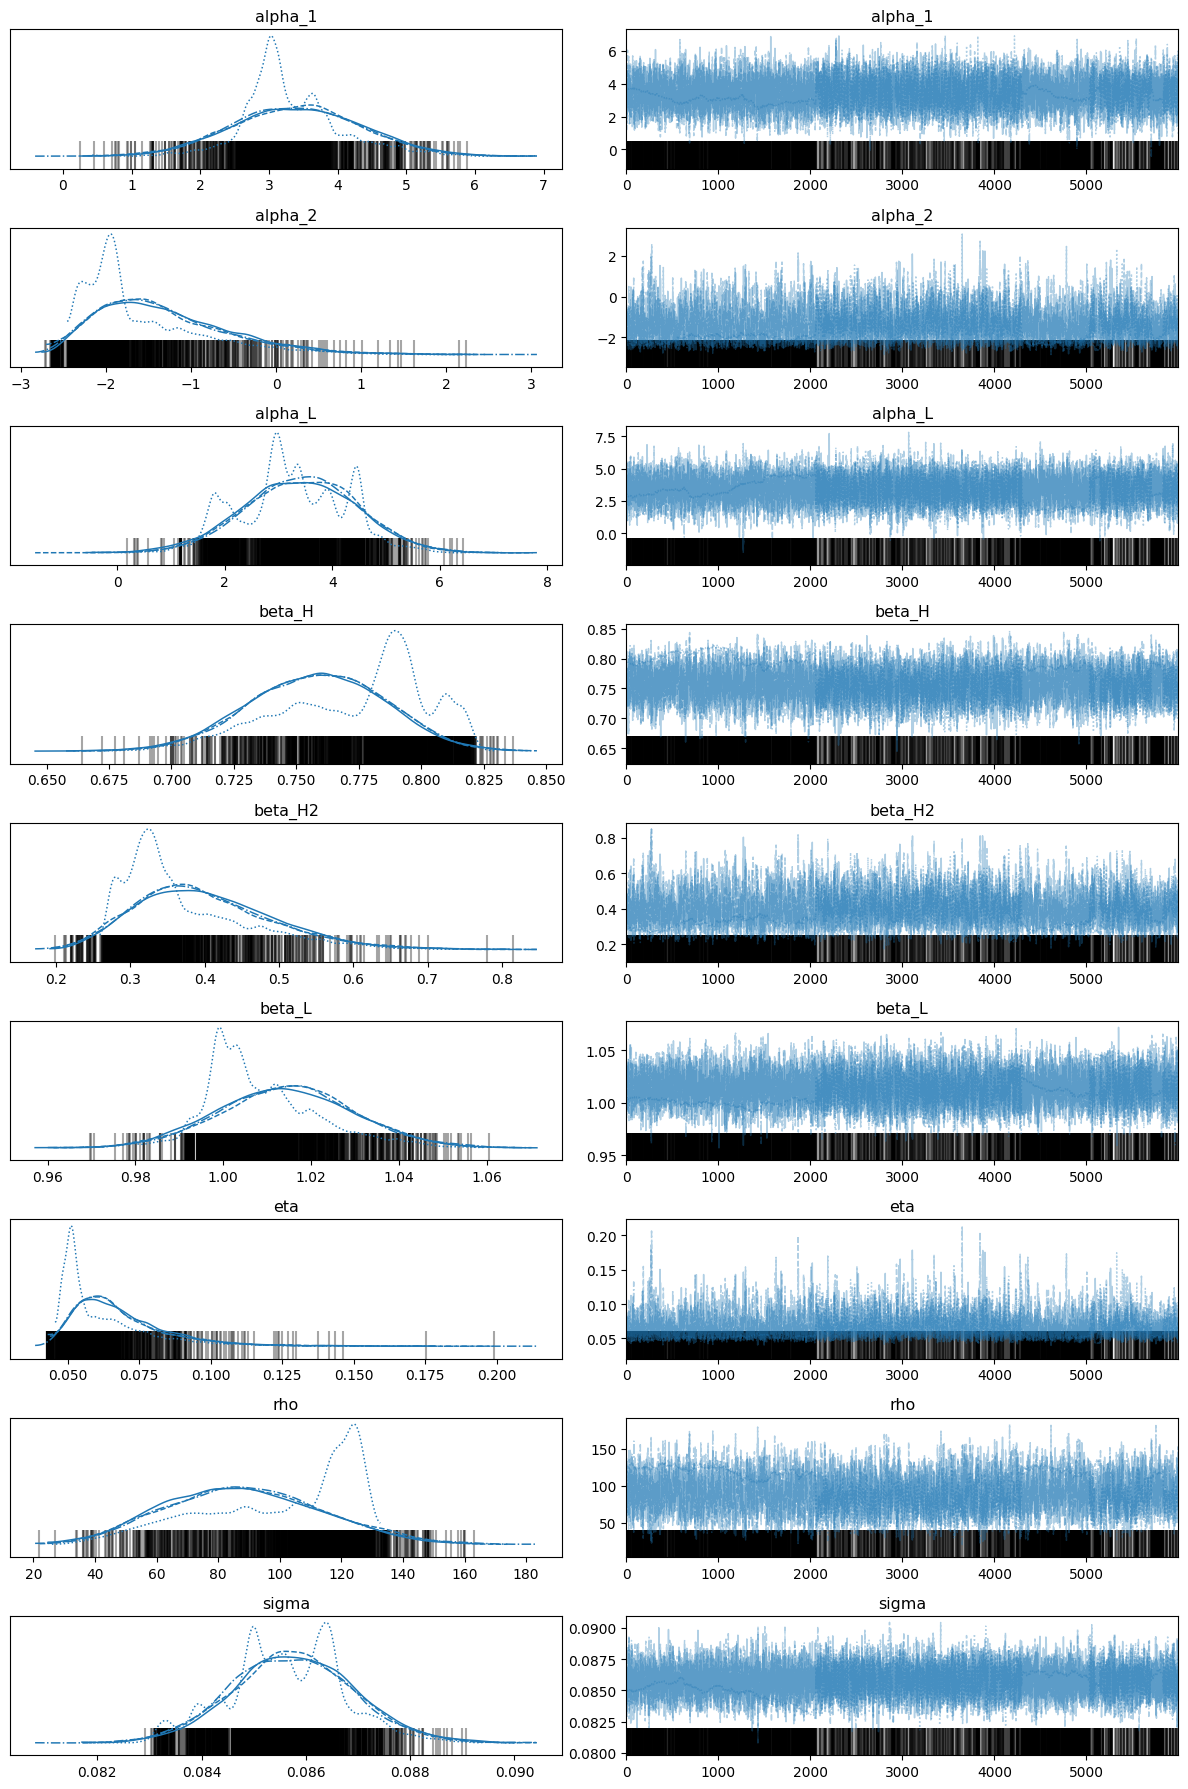

In [9]:
az.plot_trace(idata)
plt.tight_layout()

In [10]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
posterior_beta_H2 = idata["posterior"]["beta_H2"]
credible_interval_beta_H2 = np.percentile(posterior_beta_H2, [16, 50, 84])
posterior_alpha_L = idata["posterior"]["alpha_L"]
credible_interval_alpha_L = np.percentile(posterior_alpha_L, [16, 50, 84])
posterior_alpha_1 = idata["posterior"]["alpha_1"]
credible_interval_alpha_1 = np.percentile(posterior_alpha_1, [16, 50, 84])
posterior_alpha_2 = idata["posterior"]["alpha_2"]
credible_interval_alpha_2 = np.percentile(posterior_alpha_2, [16, 50, 84])
posterior_sigma = idata["posterior"]["sigma"]
credible_interval_sigma = np.percentile(posterior_sigma, [16, 50, 84])

print('eta',credible_interval_eta)
print('rho',credible_interval_rho)
print('beta_L',credible_interval_beta_L)
print('beta_H',credible_interval_beta_H)
print('beta_H2',credible_interval_beta_H2)
print('alpha_L',credible_interval_alpha_L)
print('alpha_1',credible_interval_alpha_1)
print('alpha_2',credible_interval_alpha_2)
print('sigma',credible_interval_sigma)




eta [0.05160671 0.06279174 0.08162167]
rho [ 63.94702536  90.84086656 119.6409733 ]
beta_L [0.99852029 1.01224394 1.02815017]
beta_H [0.73300572 0.7625277  0.79147162]
beta_H2 [0.30640593 0.37773169 0.4865756 ]
alpha_L [2.31537737 3.36892667 4.43218057]
alpha_1 [2.56551049 3.33742461 4.28125046]
alpha_2 [-2.12017471 -1.55839418 -0.62709493]
sigma [0.0845824  0.08570291 0.08683231]


In [11]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,3.389,0.894,1.760,5.176,0.016,0.014,2980.560,10493.126,1.015
alpha_2,-1.397,0.777,-2.582,0.074,0.054,0.046,197.225,792.894,1.022
alpha_L,3.377,1.044,1.464,5.317,0.050,0.035,444.518,4576.391,1.011
beta_H,0.762,0.028,0.714,0.818,0.004,0.003,42.090,76.953,1.063
beta_H2,0.394,0.092,0.245,0.570,0.006,0.004,236.503,1840.293,1.018
beta_L,1.013,0.015,0.986,1.042,0.002,0.001,86.662,8737.632,1.033
eta,0.067,0.017,0.045,0.099,0.002,0.001,61.332,199.256,1.044
rho,91.342,25.549,42.779,131.541,2.778,2.063,94.533,3078.342,1.033
sigma,0.086,0.001,0.084,0.088,0.000,0.000,236.074,615.366,1.021


In [12]:
posterior_eta.values.flatten()

array([0.06244277, 0.05912804, 0.05822689, ..., 0.06558255, 0.05924678,
       0.06574571])

In [13]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: 3.1244910302058155
alpha_2: -1.95935694476293
alpha_L: 2.9982938486766337
beta_H: 0.7569473568001189
beta_H2: 0.33148189871242795
beta_L: 1.0121048646619708
eta: 0.050927542218579355
rho: 124.73012960956578
sigma: 0.08501070681528078


In [14]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: 3.0474164278604974
alpha_2: -1.9466361037074744
alpha_L: 3.002836792096582
beta_H: 0.7584698252303416
beta_H2: 0.33096500553759545
beta_L: 1.0123892810260786
eta: 0.05252334024669484
rho: 87.74464970276037
sigma: 0.0854878640583024


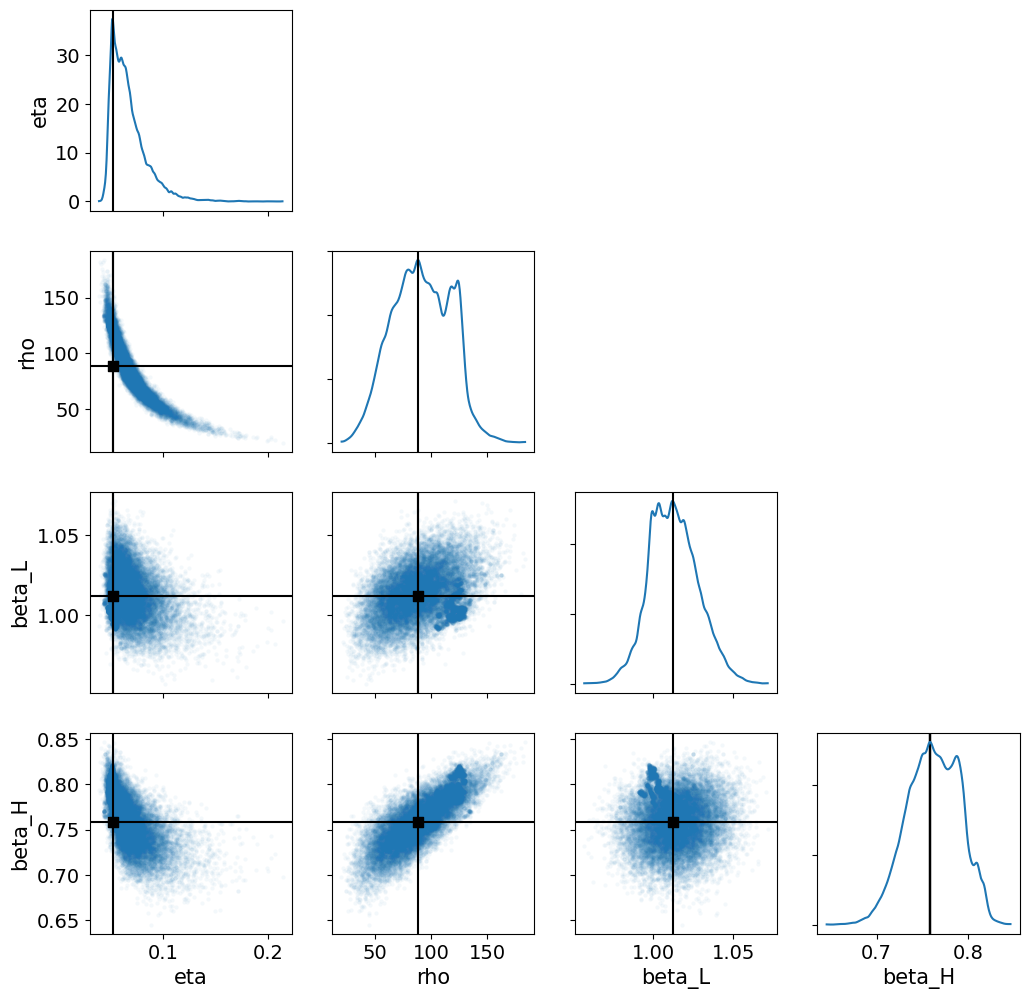

In [15]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H', 'beta_H2', 'alpha_L', 'alpha_1', 'alpha_2']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2): [ 8.69758283e+01  6.50670305e-02  1.01608659e+00  7.54511606e-01
  3.90670107e-01  3.52869602e+00  3.45699557e+00 -1.48343083e+00]


In [17]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [18]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [19]:
loss

0.6449679782898841